In [71]:
# Imports and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           f1_score, precision_score, recall_score,mean_squared_error,log_loss)


from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier



import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# For Jupyter notebook - ensure plots display inline
%matplotlib inline


In [115]:

#Defines the class

class ChessWinnerPredictor:
    def __init__(self, data_base): #Constructor
        """Initialize the chess winner predictor"""
        self.data_to_model = data_base #Creates attributes to the object
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.selected_features = None
        self.feature_scores = None
        self.le = LabelEncoder()
        
    def load_and_prepare_data(self):
        """Load CSV file and prepare data for modeling"""
        print("Loading data...")
        #self.df = pd.read_csv(self.csv_file_path)
        self.df = self.data_to_model
        
        print(f"Dataset shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        print(f"\nTarget distribution:")
        print(self.df['winner'].value_counts())
        
        # Handle missing values
        print(f"\nMissing values per column:")
        missing_values = self.df.isnull().sum()
        print(missing_values[missing_values > 0])
        
        # Prepare features (exclude id and winner columns)
        feature_columns = [col for col in self.df.columns if col not in ['id', 'winner']]
        self.X = self.df[feature_columns].copy()
        
        # Handle categorical variables if any
        for col in self.X.columns:
            if self.X[col].dtype == 'object':
                self.X[col] = LabelEncoder().fit_transform(self.X[col].astype(str))
        
        # Fill missing values with median for numeric columns
        self.X = self.X.fillna(self.X.median())
        
        # Encode target variable
        self.y = self.le.fit_transform(self.df['winner'])
        
        print(f"Feature matrix shape: {self.X.shape}")
        print(f"Target classes: {dict(zip(self.le.classes_, range(len(self.le.classes_))))}")
        
    def feature_selection(self, methods=['univariate', 'rfe', 'xgboost'], k_best=20):
        """Perform feature selection using multiple methods"""
        print(f"\n=== FEATURE SELECTION ===")
        
        # Split data first
        X_temp, _, y_temp, _ = train_test_split(self.X, self.y, test_size=0.2, 
                                                random_state=42, stratify=self.y)
        
        selected_features_dict = {}
        
        # 1. Univariate Feature Selection
        if 'univariate' in methods:
            print("1. Univariate Feature Selection (f_classif)...")
            selector_univariate = SelectKBest(score_func=f_classif, k=min(k_best, self.X.shape[1]))
            X_selected = selector_univariate.fit_transform(X_temp, y_temp)
            
            feature_scores = pd.DataFrame({
                'feature': self.X.columns,
                'score': selector_univariate.scores_,
                'p_value': selector_univariate.pvalues_
            }).sort_values('score', ascending=False)
            
            selected_features_dict['univariate'] = feature_scores.head(k_best)['feature'].tolist()
            print(f"Top 10 features by univariate selection:")
            print(feature_scores.head(10)[['feature', 'score']])
        
        # 2. Recursive Feature Elimination
        if 'rfe' in methods:
            print(f"\n2. Recursive Feature Elimination...")
            estimator = XGBClassifier(random_state=42, eval_metric='logloss')
            rfe = RFE(estimator=estimator, n_features_to_select=min(k_best, self.X.shape[1]))
            rfe.fit(X_temp, y_temp)
            
            selected_features_dict['rfe'] = self.X.columns[rfe.support_].tolist()
            print(f"Selected {sum(rfe.support_)} features with RFE")
        
        # 3. Model-based Feature Selection
        if 'xgboost' in methods:
            print(f"\n3. Model-based Feature Selection...")
            estimator = XGBClassifier(random_state=42, eval_metric='logloss')
            estimator.fit(X_temp, y_temp)
            
            selector_model = SelectFromModel(estimator, prefit=True, max_features=k_best)
            selected_features_dict['model_based'] = self.X.columns[selector_model.get_support()].tolist()
            print(f"Selected {sum(selector_model.get_support())} features with model-based selection")
        
        # Combine features from all methods
        all_selected = set()
        for method, features in selected_features_dict.items():
            all_selected.update(features)
        
        self.selected_features = list(all_selected)
        print(f"\nTotal unique features selected: {len(self.selected_features)}")
        
        # Store feature importance for later visualization
        if 'xgboost' in methods:
            self.feature_scores = pd.DataFrame({
                'feature': self.X.columns,
                'importance': estimator.feature_importances_
            }).sort_values('importance', ascending=False)
        
        return selected_features_dict
        

    def train_model_xgboost(self, use_feature_selection=True, perform_grid_search=True):
        print(f"\n=== MODEL TRAINING ===")

        # Use selected features or all features
        if use_feature_selection and self.selected_features:
            X_final = self.X[self.selected_features]
            print(f"Using {len(self.selected_features)} selected features")
        else:
            X_final = self.X
            print(f"Using all {X_final.shape[1]} features")

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_final, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        
        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")

        if perform_grid_search:
            print("Performing hyperparameter tuning...")
            
            # Define parameter grid
            param_grid = {
            'n_estimators': [100, 300, 500],
            'max_depth': [ 4, 5, 6, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.7, 0.8, 0.9],
            'max_bin': [32, 64, 128], #'max_bin': [32, 64, 128, 256, 512]
            'colsample_bytree': [0.7, 0.8, 0.9]
            #'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
            #'reg_lambda': [1, 1.5, 2]  # L2 regularization
            # 'min_child_weight': [1, 3, 5]  # Helps with overfitting
            }
            
            # Grid search
            xgb_model = XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            # objective='binary:logistic', # para win y loss nada mas
            tree_method = 'hist'  #next steps are hist and approx
            # enable_categorical=True  # If you have categorical features
            )
            
            grid_search = GridSearchCV(
            estimator = xgb_model,
            param_grid = param_grid,
            scoring = 'accuracy', #iterate between accuracy and neg_log_loss
            cv= 5, #StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # 5 fixed is the basic
            n_jobs= -1,
            verbose= 1,
            return_train_score=True  # Monitor overfitting
            )
            grid_search.fit(self.X_train, self.y_train)
            self.model = grid_search.best_estimator_
            
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        else:
            # Train with default parameters
            self.model = XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            n_estimators=200,
            max_depth=4,
            learning_rate=0.1
            )
            self.model.fit(self.X_train, self.y_train)
        
            print("Model training completed!")


    def train_model_randomforest(self, use_feature_selection=True, perform_grid_search=True, penalty_mode="both"):
        print(f"\n=== MODEL TRAINING ===")

        # Use selected features or all features
        if use_feature_selection and self.selected_features:
            X_final = self.X[self.selected_features]
            print(f"Using {len(self.selected_features)} selected features")
        else:
            X_final = self.X
            print(f"Using all {X_final.shape[1]} features")

        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_final, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        
        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")

        if perform_grid_search:
            print("Performing hyperparameter tuning...")
            param_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
            }

            rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
            grid_search = GridSearchCV(
            estimator=rf_model,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            verbose=1)
            
            grid_search.fit(self.X_train, self.y_train)
            self.model = grid_search.best_estimator_
            
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
            print("Model training completed!")

        else:
            # Train with default parameters
            self.model = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1)
            self.model.fit(self.X_train, self.y_train)
                
            print("Model training completed!")


    def train_model_logistic(self, use_feature_selection=True, perform_grid_search=True, penalty_mode="both"):
        print(f"\n=== LOGISTIC REGRESSION MODEL TRAINING ===")

        # Use selected features or all features
        if use_feature_selection and self.selected_features:
            X_final = self.X[self.selected_features]
            print(f"Using {len(self.selected_features)} selected features")
        else:
            X_final = self.X
            print(f"Using all {X_final.shape[1]} features")

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X_final, self.y, test_size=0.2, random_state=42, stratify=self.y)
    
        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")

        # Scale the features (essential for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)

        # === LÍNEAS NUEVAS: guarda los escalados en el objeto ===
        self.X_train_scaled = X_train_scaled
        self.X_test_scaled  = X_test_scaled 
        self.scaler = scaler

        if perform_grid_search:
            print("Performing hyperparameter tuning...")

                # Elegir penalización y solver según lo que quieras probar
            if penalty_mode == "ridge":  # solo L2
                param_grid = [{
                    "penalty": ["l2"],
                    "solver": ["lbfgs", "newton-cg", "liblinear", "saga"],
                    "C": [0.01, 0.1, 1, 10, 100],
                    "class_weight": [None, "balanced"],
                    "max_iter": [1000, 2000],
                }]
            elif penalty_mode == "lasso":  # solo L1
                param_grid = [{
                    "penalty": ["l1"],
                    "solver": ["liblinear", "saga"],           # L1 solo con estos
                    "C": [0.01, 0.1, 1, 10, 100],
                    "class_weight": [None, "balanced"],
                    "max_iter": [1000, 2000],
                }]
            elif penalty_mode == "elasticnet":  # mezcla L1/L2
                param_grid = [{
                    "penalty": ["elasticnet"],
                    "solver": ["saga"],                        # elasticnet solo con saga
                    "l1_ratio": [0.1, 0.5, 0.9],
                    "C": [0.01, 0.1, 1, 10, 100],
                    "class_weight": [None, "balanced"],
                    "max_iter": [1000, 2000],
                }]
            else:  # "both": probar L1 y L2
                param_grid = [
                    {   # L2 con solvers que soportan L2
                        "penalty": ["l2"],
                        "solver": ["lbfgs", "newton-cg", "liblinear", "saga"],
                        "C": [0.01, 0.1, 1, 10, 100],
                        "class_weight": [None, "balanced"],
                        "max_iter": [1000, 2000],
                    },
                    {   # L1 solo con solvers válidos
                        "penalty": ["l1"],
                        "solver": ["liblinear", "saga"],
                        "C": [0.01, 0.1, 1, 10, 100],
                        "class_weight": [None, "balanced"],
                        "max_iter": [1000, 2000],
                    },
                ]

        
        
            # Grid search
            lr_model = LogisticRegression(random_state=42)
        
            grid_search = GridSearchCV(
            estimator=lr_model,
            param_grid=param_grid,
            scoring='accuracy',  # iterate between accuracy and neg_log_loss
            cv=5,  # StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # 5 fixed is the basic
            n_jobs=-1,
            verbose=1,
            return_train_score=True  # Monitor overfitting
                )
            grid_search.fit(X_train_scaled, self.y_train)
            self.model = grid_search.best_estimator_
            
        
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        else:
            # Train with default parameters
            self.model = LogisticRegression(
            random_state=42,
            C=1.0,
            penalty='l2',
            solver='liblinear',
            max_iter=1000)
            self.model.fit(X_train_scaled, self.y_train)
    
            print("Model training completed!")
    
        # Store the scaler for later use in predictions
        self.scaler = scaler


    def train_model_lightgbm(self, use_feature_selection=True, perform_grid_search=True):
        print(f"\n=== LIGHTGBM MODEL TRAINING ===")

        # Use selected features or all features
        if use_feature_selection and self.selected_features:
            X_final = self.X[self.selected_features]
            print(f"Using {len(self.selected_features)} selected features")
        else:
            X_final = self.X
            print(f"Using all {X_final.shape[1]} features")

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X_final, self.y, test_size=0.2, random_state=42, stratify=self.y)
    
        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")

        if perform_grid_search:
            print("Performing hyperparameter tuning...")
        
        # Define parameter grid
            param_grid = {
            'n_estimators': [100, 300, 500],
            'max_depth': [4, 5, 6, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9],
            'num_leaves': [15, 31, 63],  # LightGBM specific
            'min_child_samples': [10, 20, 30],  # LightGBM specific
            #'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
            #'reg_lambda': [0, 0.1, 0.5]  # L2 regularization
            }
        
        # Grid search
            lgb_model = lgb.LGBMClassifier(
            random_state=42,
            objective='binary',
            metric='binary_logloss',
            verbose=-1,  # Suppress warnings
            force_row_wise=True  # Better for small datasets
            )
        
            grid_search = GridSearchCV(
            estimator=lgb_model,
            param_grid=param_grid,
            scoring='accuracy',  # iterate between accuracy and neg_log_loss
            cv=5,  # StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # 5 fixed is the basic
            n_jobs=-1,
            verbose=1,
            return_train_score=True  # Monitor overfitting
                )
            grid_search.fit(self.X_train, self.y_train)
            self.model = grid_search.best_estimator_
        
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        else:
            # Train with default parameters
            self.model = lgb.LGBMClassifier(
            random_state=42,
            objective='binary',
            metric='binary_logloss',
            n_estimators=200,
            max_depth=4,
            learning_rate=0.1,
            verbose=-1
            )
            self.model.fit(self.X_train, self.y_train)
    
            print("Model training completed!")

    
    
    def evaluate_model(self):
        """Comprehensive model evaluation"""
        print("\n=== MODEL EVALUATION ===")

        # Usa escalados si existen (logística) o normales (RF/XGB/LGBM)
        X_test_eval  = self.X_test_scaled  if hasattr(self, "X_test_scaled")  else self.X_test
        X_train_eval = self.X_train_scaled if hasattr(self, "X_train_scaled") else self.X_train
    
        # Predicciones
        y_pred       = self.model.predict(X_test_eval)
        y_pred_train = self.model.predict(X_train_eval)
        y_pred_proba = self.model.predict_proba(X_test_eval)
    
        # Métricas básicas
        accuracy  = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall    = recall_score(self.y_test, y_pred)
        f1        = f1_score(self.y_test, y_pred)
        auc_score = roc_auc_score(self.y_test, y_pred_proba[:, 1])
        logloss_direct = log_loss(self.y_test, y_pred_proba)
    
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc_score:.4f}")
        print(f"LogLoss: {logloss_direct:.4f}")
    
        # Reporte por clase
        print("\nClassification Report:")
        target_names = self.le.classes_
        print(classification_report(self.y_test, y_pred, target_names=target_names))

        # Cross-validation en el set de entrenamiento correspondiente
        from sklearn.model_selection import cross_val_score
        cv_scores = cross_val_score(self.model, X_train_eval, self.y_train, cv=5, scoring='accuracy')
        print(f"\nCross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc_score": auc_score,
            "cv_scores": cv_scores,
            "logloss_direct": logloss_direct,
        }


    
    def create_visualizations(self):
        """Create comprehensive visualizations"""
        print(f"\n=== CREATING VISUALIZATIONS ===")
        
        # Predictions for plots
        #y_pred = self.model.predict(self.X_test)
        #y_pred_proba = self.model.predict_proba(self.X_test)

        # === LÍNEAS NUEVAS: usa los valores escalados para la visualizacion ===
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred_proba = self.model.predict_proba(self.X_test_scaled)

        # Create subplot layout
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Confusion Matrix
        plt.subplot(2, 3, 1)
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        # 2. ROC Curve
        plt.subplot(2, 3, 2)
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba[:, 1])
        auc_score = roc_auc_score(self.y_test, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        
        # 3. Precision-Recall Curve
        plt.subplot(2, 3, 3)
        precision_vals, recall_vals, _ = precision_recall_curve(self.y_test, y_pred_proba[:, 1])
        plt.plot(recall_vals, precision_vals)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        
        # 4. Feature Importance (Top 15)
        plt.subplot(2, 3, 4)
        if hasattr(self.model, 'feature_importances_'):
            if hasattr(self, 'selected_features') and self.selected_features:
                feature_names = self.selected_features
            else:
                feature_names = self.X.columns
                
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=True).tail(15)
            
            plt.barh(range(len(importance_df)), importance_df['importance'])
            plt.yticks(range(len(importance_df)), importance_df['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 15 Feature Importances')
        
        # 5. Prediction Probability Distribution
        plt.subplot(2, 3, 5)
        plt.hist(y_pred_proba[:, 1], bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Predicted Probability (White Win)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Probabilities')
        plt.grid(True)
        
        # 6. Learning Curve (if we have training history)
        plt.subplot(2, 3, 6)
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        plt.bar(range(1, 6), cv_scores)
        plt.xlabel('CV Fold')
        plt.ylabel('Accuracy')
        plt.title('Cross-Validation Scores')
        plt.ylim([min(cv_scores)-0.01, max(cv_scores)+0.01])
        
        for i, score in enumerate(cv_scores):
            plt.text(i+1, score+0.001, f'{score:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Feature importance comparison (if feature selection was used)
        if hasattr(self, 'feature_scores') and self.feature_scores is not None:
            plt.figure(figsize=(12, 8))
            top_features = self.feature_scores.head(20)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 20 Features by Importance (XGBoost)')
            plt.tight_layout()
            plt.show()
            
        # Return plots for Jupyter display
        return fig
    
    def run_complete_analysis(self, csv_file_path=None):
        """Run the complete analysis pipeline"""
        if csv_file_path:
            self.csv_file_path = csv_file_path
            
        print("Starting Chess Winner Prediction Analysis...")
        print("="*50)
        
        # Step 1: Load and prepare data
        self.load_and_prepare_data()
        
        # Step 2: Feature selection
        feature_selection_results = self.feature_selection()
        
        # Step 3: Train model
        self.train_model(use_feature_selection=True, perform_grid_search=True)
        
        # Step 4: Evaluate model
        evaluation_metrics = self.evaluate_model()
        
        # Step 5: Create visualizations
        self.create_visualizations()
        
        print("\n" + "="*50)
        print("Analysis completed successfully!")
        
        return evaluation_metrics

# Usage example for Jupyter Notebook:
"""
if __name__ == "__main__":
    # In Jupyter, you can run this cell by cell or all at once
    
    # Step 1: Initialize the predictor
    predictor = ChessWinnerPredictor("your_chess_data.csv")  # Replace with your CSV file path
    
    # Step 2: Run complete analysis
    results = predictor.run_complete_analysis()
    
    # Step 3: Print final summary
    print(f"\n=== FINAL SUMMARY ===")
    print(f"Model Accuracy: {results['accuracy']:.4f}")
    print(f"AUC Score: {results['auc_score']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
"""

# Alternative: Run step by step in Jupyter cells
"""
# Cell 1: Initialize and load data
predictor = ChessWinnerPredictor("your_chess_data.csv")
predictor.load_and_prepare_data()

# Cell 2: Feature selection
feature_results = predictor.feature_selection()

# Cell 3: Train model
predictor.train_model(use_feature_selection=True, perform_grid_search=True)

# Cell 4: Evaluate model
evaluation_metrics = predictor.evaluate_model()

# Cell 5: Create visualizations
plots = predictor.create_visualizations()
"""

'\n# Cell 1: Initialize and load data\npredictor = ChessWinnerPredictor("your_chess_data.csv")\npredictor.load_and_prepare_data()\n\n# Cell 2: Feature selection\nfeature_results = predictor.feature_selection()\n\n# Cell 3: Train model\npredictor.train_model(use_feature_selection=True, perform_grid_search=True)\n\n# Cell 4: Evaluate model\nevaluation_metrics = predictor.evaluate_model()\n\n# Cell 5: Create visualizations\nplots = predictor.create_visualizations()\n'

In [117]:
# Paso 1: Cargar los datos

chess_db = pd.read_csv("basic_chess_munged_db.csv") #apuntar al csv de la base de datos

#chess_blitz = chess_db[chess_db.game_class == 1] ## utilizar si queremos manipular el csv antes de meterlo al modelo

predictor = ChessWinnerPredictor(chess_db) #prepara la variable de los datos para el modelo
predictor.load_and_prepare_data()

Loading data...
Dataset shape: (18225, 14)
Columns: ['id', 'winner', 'rated', 'victory_status_class', 'base_time', 'add_time', 'total_time', 'white_rating', 'black_rating', 'rating_dif_abs', 'rating_dif_class', 'opening_class', 'opening_eco_mod', 'opening_ply']

Target distribution:
winner
white    9545
black    8680
Name: count, dtype: int64

Missing values per column:
Series([], dtype: int64)
Feature matrix shape: (18225, 12)
Target classes: {'black': 0, 'white': 1}


In [119]:
# Paso 2: seleccion de features
### en el argumento methods podemos seleccionar alguno de los siguientes. ['univariate', 'rfe', 'xgboost']
### si no se utiliza el argumento entonces intenga agarrar los mejores de todos los algoritmos combinados
### el  argumento k_best es para seleccionar la cantidad de features deseados

feature_results = predictor.feature_selection(
    #methods= 'rfe',
    k_best=10
)


=== FEATURE SELECTION ===
1. Univariate Feature Selection (f_classif)...
Top 10 features by univariate selection:
                 feature        score
8       rating_dif_class  1556.992464
6           black_rating   423.798757
5           white_rating   324.446475
10       opening_eco_mod     9.354019
9          opening_class     7.307769
11           opening_ply     6.628388
0                  rated     2.243764
7         rating_dif_abs     1.043606
1   victory_status_class     0.528033
3               add_time     0.291897

2. Recursive Feature Elimination...
Selected 10 features with RFE

3. Model-based Feature Selection...
Selected 1 features with model-based selection

Total unique features selected: 12


In [127]:
# Paso 3: entrenar el modelo
## todos los modelos tienen dos argumentos:
### use_feature_selection = TRUE, usa los features seleccionados en paso 2. Si es false entonces usa todos los features de la tabla
### perform_grid_search = TRUE, ajusta los parametros con validacion cruzada utilizada la malla (grid) que se define en la funcion. Si es FALSE, utiliza parametos fijos definidas en la funcion

#Descomentar y Correr 1 de los siguientes:

 # === LÍNEAS NUEVAS: modelo Ridge (penalty_mode="ridge") y Lasso penalty_mode="lasso", amobs y grid elige (penalty_mode="both") Elasticnet (mezcla los dos)(penalty_mode="elasticnet") ===

predictor.train_model_logistic( use_feature_selection=True, perform_grid_search=True, penalty_mode="ridge") ## Modelo regresion logisitca

#predictor.train_model_randomforest( use_feature_selection=True, perform_grid_search=True) ## Modelo RandomForest

#predictor.train_model_xgboost( use_feature_selection=True, perform_grid_search=True) ## Modelo XGBoost

#predictor.train_model_lightgbm( use_feature_selection=True, perform_grid_search=True) ## Modelo LGBM




=== LOGISTIC REGRESSION MODEL TRAINING ===
Using 12 selected features
Training set size: (14580, 12)
Test set size: (3645, 12)
Performing hyperparameter tuning...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.6510


In [129]:
# Paso 4: Evaluar el modelo
### la funcion se creo con los parametros genericos para cualquier modelo. Si falto alguno, agregar en la funcion.

evaluation_metrics = predictor.evaluate_model()



=== MODEL EVALUATION ===
Accuracy: 0.6579
Precision: 0.6684
Recall: 0.6883
F1-Score: 0.6782
AUC-ROC: 0.7183
LogLoss: 0.6142

Classification Report:
              precision    recall  f1-score   support

       black       0.65      0.62      0.63      1736
       white       0.67      0.69      0.68      1909

    accuracy                           0.66      3645
   macro avg       0.66      0.66      0.66      3645
weighted avg       0.66      0.66      0.66      3645


Cross-validation Accuracy: 0.6510 (+/- 0.0185)



=== CREATING VISUALIZATIONS ===


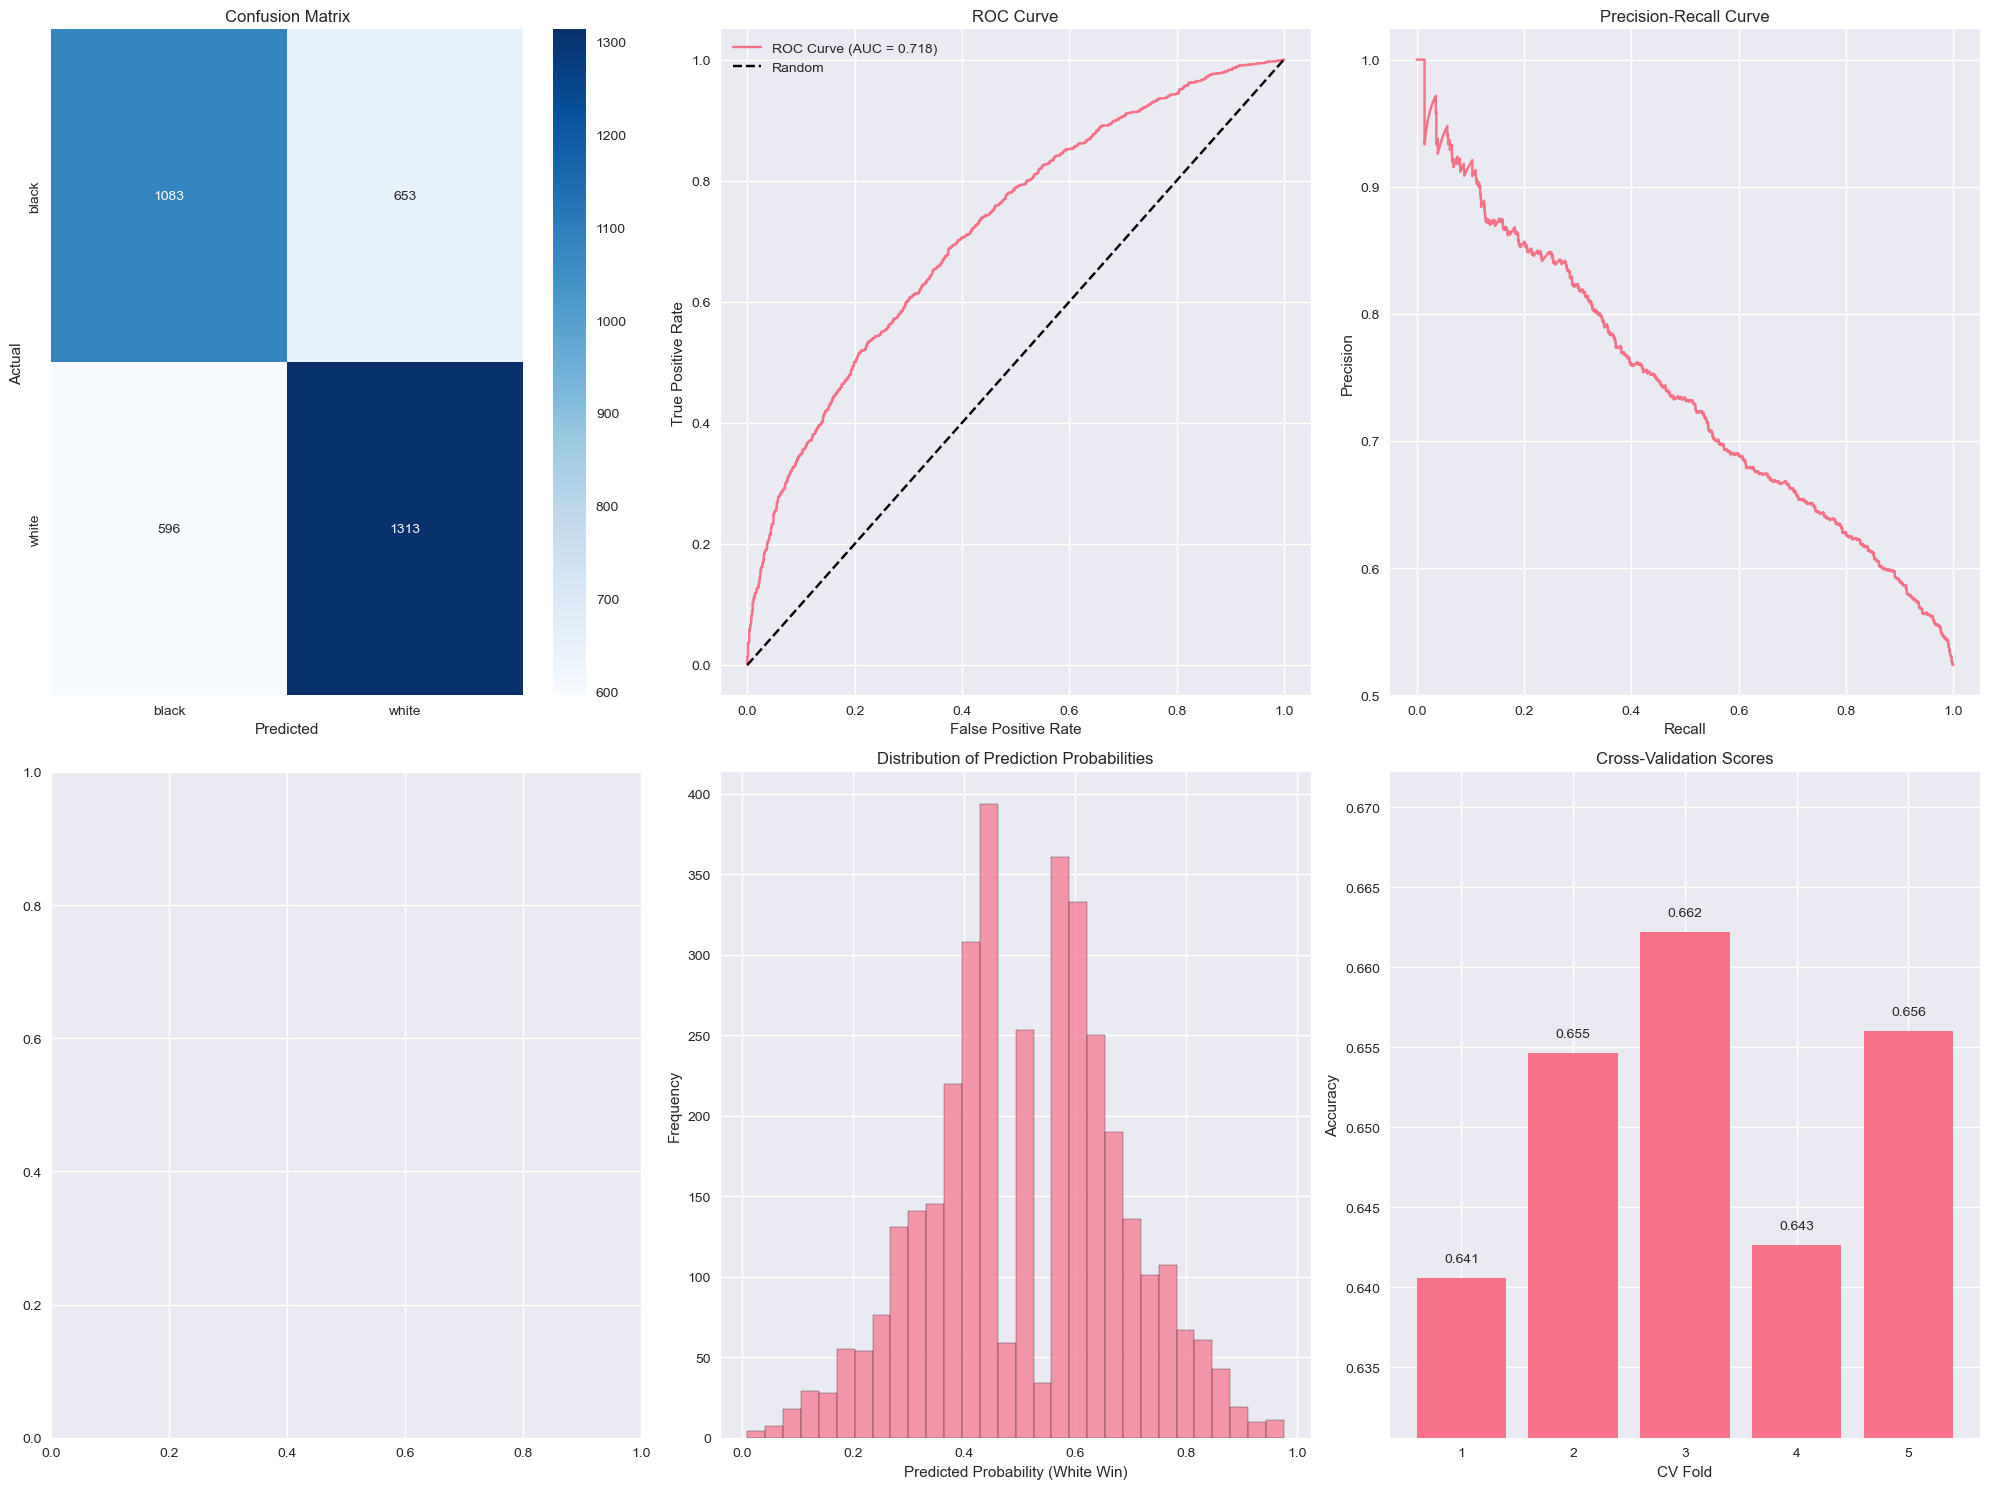

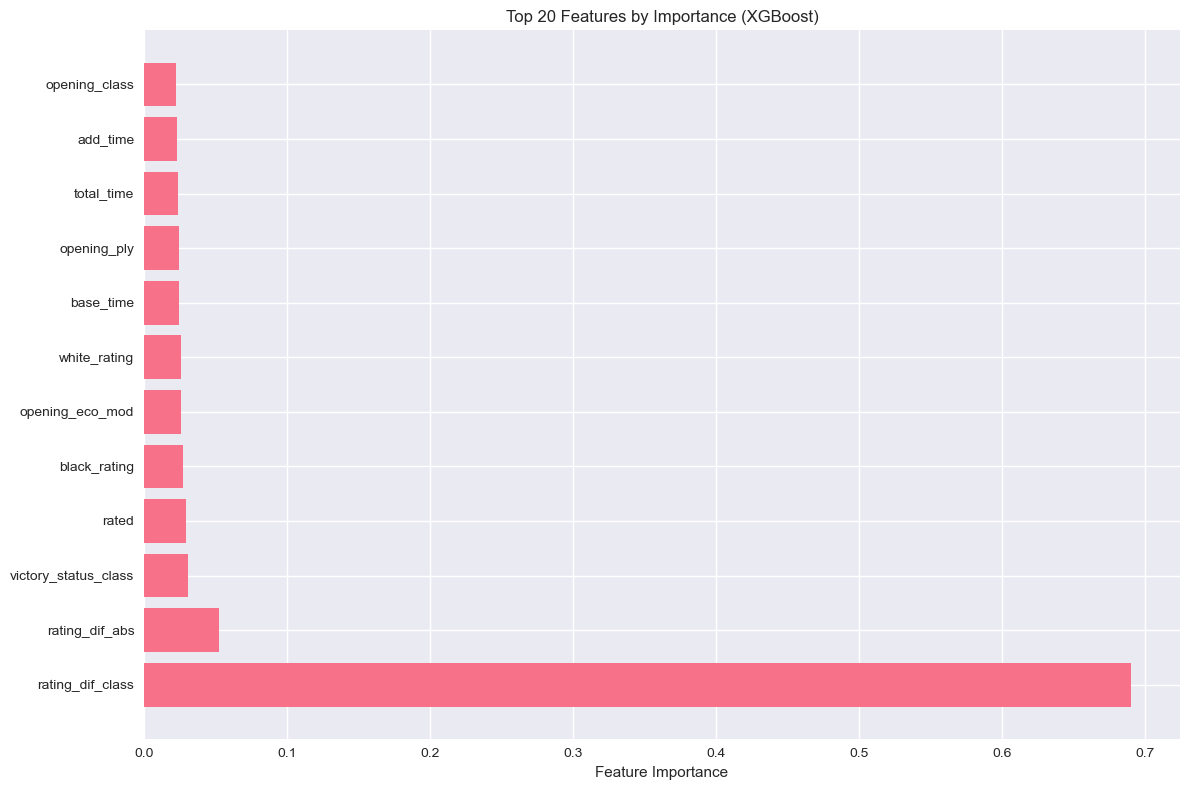

In [103]:
# Paso 5: Crear la visualizaciones para medir el modelo. 
###Ojo que la visualizacion de features esta atada al paso 3.

plots = predictor.create_visualizations()